In [2]:
import json

# Load JSON data
with open("filtered_data.json", "r") as f:
    bird_data = json.load(f)


import os

# ✅ Extract Bird Species Labels
labels = list(bird_data.keys())  # List all bird species
label_mapping = {species: idx for idx, species in enumerate(labels)}  # Assign numeric labels
reverse_label_mapping = {idx: species for species, idx in label_mapping.items()}  # Label → Bird

print(f"✅ Bird Species: {labels}")
print(f"✅ Label Mapping: {label_mapping}")

import os

data_list = []  # Stores (file_path, label) pairs
base_path = "wavfiles"  # Base directory for WAV files

# ✅ Collect File Paths & Labels
for bird_name, bird_list in bird_data.items():
    label = label_mapping[bird_name]
    for bird in bird_list:
        file_path = os.path.join(base_path, bird["filename"])

        # ✅ Check if file exists before adding
        if os.path.exists(file_path):
            data_list.append((file_path, label))
        else:
            print(f"⚠️ File not found: {file_path}")  # Debug missing files

print(f"✅ Total Files Processed: {len(data_list)}")
print(data_list)

✅ Bird Species: ['American Robin', "Bewick's Wren", 'Northern Cardinal', 'Northern Mockingbird', 'Song Sparrow']
✅ Label Mapping: {'American Robin': 0, "Bewick's Wren": 1, 'Northern Cardinal': 2, 'Northern Mockingbird': 3, 'Song Sparrow': 4}
✅ Total Files Processed: 500
[('wavfiles\\562221-1.wav', 0), ('wavfiles\\564324-5.wav', 0), ('wavfiles\\129798-0.wav', 0), ('wavfiles\\423449-0.wav', 0), ('wavfiles\\446458-1.wav', 0), ('wavfiles\\559314-7.wav', 0), ('wavfiles\\165292-8.wav', 0), ('wavfiles\\14442-13.wav', 0), ('wavfiles\\423449-2.wav', 0), ('wavfiles\\129798-13.wav', 0), ('wavfiles\\446458-0.wav', 0), ('wavfiles\\165272-7.wav', 0), ('wavfiles\\103060-14.wav', 0), ('wavfiles\\175222-10.wav', 0), ('wavfiles\\483578-15.wav', 0), ('wavfiles\\322887-8.wav', 0), ('wavfiles\\34766-11.wav', 0), ('wavfiles\\322822-8.wav', 0), ('wavfiles\\562449-6.wav', 0), ('wavfiles\\368615-10.wav', 0), ('wavfiles\\464766-9.wav', 0), ('wavfiles\\138063-8.wav', 0), ('wavfiles\\138063-7.wav', 0), ('wavfiles

In [4]:
import torch
import torchaudio.transforms as T
import torchvision.transforms as transforms

# ✅ Define Transformations for Training
class MelTransform:
    def __init__(self, target_size=(128, 128)):
        self.resize = transforms.Resize(target_size)  # ✅ Resize to smaller shape

    def __call__(self, mel_spec):
        # ✅ Resize Spectrogram to Target Size
        mel_spec = self.resize(mel_spec.unsqueeze(0))  # Add channel dim for resizing
        mel_spec = mel_spec.squeeze(0)  # Remove extra dimension after resizing
        return mel_spec


In [5]:
import torch
import librosa
from torch.utils.data import Dataset
import numpy as np

class BirdSoundDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        self.transform = MelTransform()  


    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        file_path, label = self.data_list[idx]
        y, sr = librosa.load(file_path, sr=None)  # Load with original sample rate

        # ✅ Compute Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # ✅ Convert to PyTorch Tensor
        mel_tensor = torch.tensor(mel_spec_db, dtype=torch.float32).unsqueeze(0)  # ✅ Add channel dimension (1, 64, 64)
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        #transform
        mel_tensor=self.transform(mel_tensor)
        

        return mel_tensor,sr, label_tensor,file_path

# ✅ Initialize Dataset
dataset = BirdSoundDataset(data_list)
print(f"✅ Dataset Initialized: {len(dataset)} samples")

from torch.utils.data import DataLoader

# ✅ Create DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

from sklearn.model_selection import train_test_split

# ✅ Split Data: 80% Train, 10% Validation, 10% Test
train_files, temp_files = train_test_split(
    dataset.data_list, test_size=0.2, random_state=42, stratify=[label for _, label in dataset.data_list]
)

val_files, test_files = train_test_split(
    temp_files, test_size=0.5, random_state=42, stratify=[label for _, label in temp_files]
)

print(f"✅ Training Samples: {len(train_files)}")
print(f"✅ Validation Samples: {len(val_files)}")
print(f"✅ Testing Samples: {len(test_files)}")

# ✅ Define Batch Size
batch_size = 16  # Increased for more stable training

# ✅ Create Train, Validation, and Test Datasets
train_dataset = BirdSoundDataset(train_files)
val_dataset = BirdSoundDataset(val_files)
test_dataset = BirdSoundDataset(test_files)

# ✅ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Train Batches: {len(train_loader)}, Val Batches: {len(val_loader)}, Test Batches: {len(test_loader)}")

# ✅ Fetch One Batch from Train Loader
train_batch = next(iter(train_loader))
mel_specs, sample_rates, labels, file_paths = train_batch

print(f"✅ Train Batch Shape: {mel_specs.shape}")  # Expected: (batch_size, 1, 128, 128)

✅ Dataset Initialized: 500 samples
✅ Training Samples: 400
✅ Validation Samples: 50
✅ Testing Samples: 50
✅ Train Batches: 25, Val Batches: 4, Test Batches: 4
✅ Train Batch Shape: torch.Size([16, 1, 128, 128])


Northern Cardinal


Northern Mockingbird


Northern Cardinal


Song Sparrow


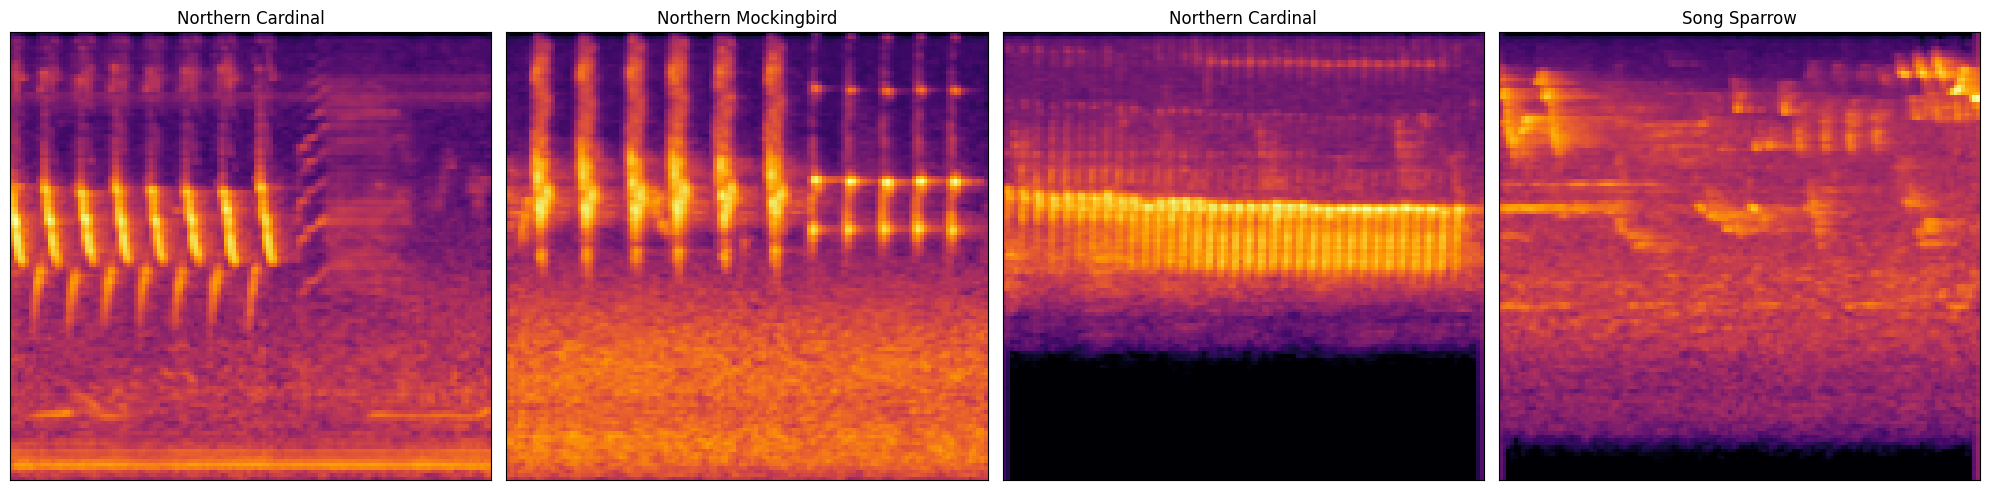

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

# ✅ Fetch One Batch from DataLoader
batch = next(iter(dataloader))  # Get first batch
mel_specs, sample_rates, labels, file_paths = batch  # Unpack spectrograms, labels, and file paths

# ✅ Convert to NumPy for Visualization
mel_specs_np = mel_specs.numpy()
sample_rates_np = sample_rates.numpy() if isinstance(sample_rates, torch.Tensor) else sample_rates  # Convert tensor to NumPy if needed

# ✅ Create a Single Figure with 4 Subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# ✅ Keep track of images for colorbar
im = None  

for i in range(4):  # Loop through first 4 samples
    img = mel_specs_np[i].squeeze(0)  # Extract one spectrogram
    sr_value = int(sample_rates_np[i])  # Convert sample rate to Python integer
    label_int = labels[i].item()  # Convert label to int
    class_name = reverse_label_mapping.get(label_int, "Unknown")  # Get class name from mapping

    print(f"{class_name}")

    # ✅ Play the Original Audio
    audio = ipd.Audio(file_paths[i], rate=sr_value)
    display(audio)

    # ✅ Plot the Mel Spectrogram & store the image
    im = librosa.display.specshow(img, sr=sr_value, cmap="inferno", ax=axes[i])
    axes[i].set_title(f"{class_name}")


# ✅ Show the Plots
plt.tight_layout()
plt.show()


